In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline
mpl.style.use('bmh')

In [212]:
import torch
import random

from itertools import permutations
from collections import defaultdict
from tqdm import tqdm_notebook
from scipy.spatial.distance import cosine

from sent_order.models.kt_regression import Corpus

In [3]:
sent_encoder = torch.load(
    '../../data/models/new/ctx-reg/sent_encoder.999.bin',
    map_location={'cuda:0': 'cpu'},
)

In [4]:
graf_encoder = torch.load(
    '../../data/models/new/ctx-reg/graf_encoder.999.bin',
    map_location={'cuda:0': 'cpu'},
)

In [5]:
regressor = torch.load(
    '../../data/models/new/ctx-reg/regressor.999.bin',
    map_location={'cuda:0': 'cpu'},
)

In [6]:
dev = Corpus('../../data/dev.json/', 10000)

100%|██████████| 10000/10000 [00:01<00:00, 7252.99it/s]


In [245]:
grafs = [g for g in dev.grafs if len(g.sentences) == 8]

In [246]:
len(grafs)

669

In [254]:
graf = grafs[160]

In [255]:
[' '.join(s.tokens) for s in graf.sentences]

['We present a three - dimensional photoionisation and dust radiative transfer model of NGC 6302 , an extreme , high - excitation planetary nebula .',
 'We use the 3D photoionisation code Mocassin } to model the emission from the gas and dust .',
 'We have produced a good fit to the optical emission - line spectrum , from which we derived a density distribution for the nebula .',
 'A fit to the infrared coronal lines places strong constraints on the properties of the unseen ionising source .',
 'We find the best fit comes from using a 220,000 K hydrogen - deficient central star model atmosphere , indicating that the central star of this PN may have undergone a late thermal pulse .',
 'We have also fitted the overall shape of the ISO spectrum of NGC 6302 using a dust model with a shallow power - law size distribution and grains up to 1.0 micron in size .',
 'To obtain a good fit to the infrared SED the dust must be sufficiently recessed within the circumstellar disk to prevent large amo

In [256]:
sents = sent_encoder(graf.sentence_variables(), 30)

In [257]:
def predict(sents, perm):
    
    sents = sents[torch.LongTensor(perm)]
    
    graf = graf_encoder([sents], 30)
    
    x = torch.stack([
        torch.cat([graf[0], sent])
        for sent in sents
    ])
    
    return regressor(x)

In [258]:
perms = list(permutations(range(len(sents))))

In [259]:
preds = defaultdict(list)

for perm in tqdm_notebook(random.sample(perms, 100)):
    for pos, val in zip(perm, predict(sents, perm)):
        preds[pos].append(val.data[0])

HBox(children=(IntProgress(value=0), HTML(value='')))

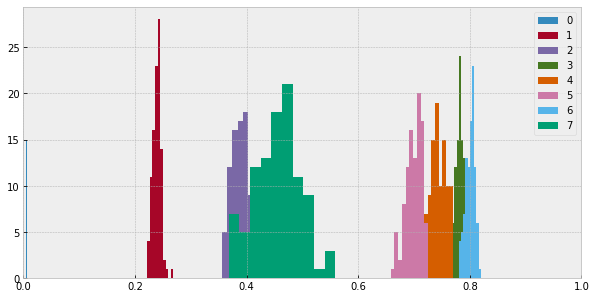

In [260]:
plt.figure(figsize=(10, 5))
plt.xlim(0, 1)
plt.set_cmap('binary')

for i in range(len(preds)):
    plt.hist(preds[i], label=str(i))
    
plt.legend()